## Setting up

Everything in this notebook has been done to classify the kind of activity the humans are doing in an image.<br>
The model here uses the inferences made by the previous model + image to classify the kind of activity the humans are doing<br>

In [13]:
import sys
sys.path.append('../src')

In [14]:
import os
import numpy as np
import copy
import json
import cv2
from matplotlib import pyplot as plt
from pymatreader import read_mat

In [15]:
dataset_path = '../data/processed'
image_files_path = "../data/raw/original_images"
dataset_path, image_files_path

('../data/processed', '../data/raw/original_images')

In [16]:
valid_annot_data = None

Load the normalised-data

In [17]:
try:
    with open(f'{dataset_path}/normalised_annot_data.json', 'r') as file:
        valid_annot_data = json.load(file)
    path = f'{dataset_path}/normalised_annot_data.json'
    print(f"[+] Normalised annotations loaded successfully from {path}")
except Exception as e:
    print("[-] Failed to load data")

[+] Normalised annotations loaded successfully from ../data/processed/normalised_annot_data.json


In [18]:
image_files_path_train = f"{dataset_path}/images_pose/train"
image_files_path_val = f"{dataset_path}/images_pose/val"
image_files_path_train, image_files_path_val

('../data/processed/images_pose/train', '../data/processed/images_pose/val')

## Read the train and val set entries

In [19]:
train_image_names = os.listdir(image_files_path_train)
val_image_names = os.listdir(image_files_path_val)
len(train_image_names), len(val_image_names)

(10414, 6953)

In [20]:
image_name_to_activity_hash = dict()
unique_activities_count = dict()

In [21]:
# Create a image_name->activity hash table
for i in range(len(valid_annot_data)):
    name = str(valid_annot_data[i]['name'])
    activity = str(valid_annot_data[i]['general_activity_name'])

    if activity == '[]': # Skip invalid categories
        continue

    image_name_to_activity_hash[name] = activity
    
    if activity in unique_activities_count:
        unique_activities_count[activity] += 1
    else:
        unique_activities_count[activity] = 0

In [22]:
len(image_name_to_activity_hash)

17367

In [23]:
len(unique_activities_count)

20

In [24]:
activity_wise_information_train = dict()
activity_wise_information_val = dict()
activity_wise_information_train, activity_wise_information_val

({}, {})

In [25]:
if len(activity_wise_information_train) == 0:
    for i in range(len(train_image_names)):
        if train_image_names[i] in image_name_to_activity_hash:
            activity = str(image_name_to_activity_hash[train_image_names[i]])

            if activity not in activity_wise_information_train:
                activity_wise_information_train[activity] = []
                (activity_wise_information_train[activity]).append(train_image_names[i])
            else:
                (activity_wise_information_train[activity]).append(train_image_names[i])

In [26]:
if len(activity_wise_information_val) == 0:
    for i in range(len(val_image_names)):
        if val_image_names[i] in image_name_to_activity_hash:
            activity = str(image_name_to_activity_hash[val_image_names[i]])

            if activity not in activity_wise_information_val:
                activity_wise_information_val[activity] = []
                (activity_wise_information_val[activity]).append(val_image_names[i])
            else:
                (activity_wise_information_val[activity]).append(val_image_names[i])

In [27]:
# Check the amount of activity in each set
unique_activities_count_train = dict()
unique_activities_count_val = dict()

for key in activity_wise_information_train.keys():
    unique_activities_count_train[key] = len(activity_wise_information_train[key])

for key in activity_wise_information_val.keys():
    unique_activities_count_val[key] = len(activity_wise_information_val[key])

In [16]:
# Let's look at the distribution of activities

In [28]:
unique_activities_count_train

{'sports': 2074,
 'conditioning exercise': 1009,
 'walking': 346,
 'occupation': 1407,
 'home activities': 828,
 'lawn and garden': 655,
 'bicycling': 309,
 'inactivity quiet/light': 111,
 'fishing and hunting': 423,
 'home repair': 639,
 'self care': 53,
 'water activities': 605,
 'miscellaneous': 445,
 'running': 175,
 'dancing': 418,
 'winter activities': 444,
 'music playing': 322,
 'religious activities': 72,
 'transportation': 52,
 'volunteer activities': 27}

In [29]:
unique_activities_count_val

{'fishing and hunting': 283,
 'occupation': 938,
 'sports': 1383,
 'miscellaneous': 298,
 'home repair': 426,
 'water activities': 404,
 'lawn and garden': 437,
 'conditioning exercise': 673,
 'dancing': 279,
 'home activities': 552,
 'bicycling': 207,
 'religious activities': 48,
 'walking': 231,
 'winter activities': 296,
 'music playing': 216,
 'transportation': 36,
 'inactivity quiet/light': 74,
 'running': 117,
 'self care': 36,
 'volunteer activities': 19}

In [30]:
class_names = {
 'sports': 0,
 'miscellaneous': 1,
 'home activities': 2,
 'occupation': 3,
 'fishing and hunting': 4,
 'home repair': 5,
 'conditioning exercise': 6,
 'lawn and garden': 7,
 'religious activities': 8,
 'music playing': 9,
 'inactivity quiet/light': 10,
 'water activities': 11,
 'running': 12,
 'winter activities': 13,
 'walking': 14,
 'dancing': 15,
 'bicycling': 16,
 'transportation': 17,
 'self care': 18,
 'volunteer activities': 19
}

train_data_images, val_data_images contain the image names for the training and validation set respectively, similarly train_data_label and <br>
val_data_label contain the labels for training and validation data

In [31]:
train_data_images, val_data_images = [], []
train_data_label, val_data_label = [], []

In [32]:
for key in activity_wise_information_train.keys():
    size = len(activity_wise_information_train[key])
    
    for j in range(min(150, len(activity_wise_information_train[key]))): # taking 150 instances of each activity(taking a 1/3 approach)
        name = activity_wise_information_train[key][j]
        train_data_images.append(name)
        train_data_label.append(class_names[key])

In [33]:
for key in activity_wise_information_val.keys():
    size = len(activity_wise_information_val[key])
    
    for j in range(min(60, len(activity_wise_information_val[key]))): # taking 50 instainces of each activity(taking a 1/3 approach)
        name = activity_wise_information_val[key][j]
        val_data_images.append(name)
        val_data_label.append(class_names[key])

In [34]:
len(train_data_images), len(val_data_images)

(2565, 1099)

In [35]:
len(train_data_label), len(val_data_label)

(2565, 1099)

In [26]:
# Import the keypoint estimation model and make inferences on training and validation set, so as to generate the dataset for the pose_classification
# model

In [36]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

In [37]:
model_path = './runs/pose/train2/weights/last.pt'
image_path_to_feed = '../data/processed/images_pose/train'
model_path, image_path_to_feed

('./runs/pose/train2/weights/last.pt', '../data/processed/images_pose/train')

Importing the keypoint estimation model

In [38]:
# Import the model
model = YOLO(model_path)

In [39]:
from utilities.utils import calc_bbox_coordinates
from utilities.utils import calcEuclideanDistance
from utilities.utils import clear_files_in_directory
from utilities.utils import plot_bar_graph
from data.dataset_saver import save_dataset

In [40]:
image_height, image_width = 480, 640
image_height, image_width

(480, 640)

In [41]:
skeleton_data = [
        [0, 1], # right_ankle right_knee
        [1, 2], # right_knee right_hip
        [2, 6], # right_hip pelvis
        [6, 3], # pelvis left_hip
        [3, 4], # left_hip left_knee
        [4, 5], # left_knee left_ankle
        [12, 11], # right_shoulder right_elbow
        [11, 10], # right_elbow right_wrist
        [13, 14], # left_shoulder left_elbow
        [14, 15], # left_elbow left_wrist
        [2, 12], # right_hip right_shoulder
        [3, 13], # left_hip left_shoulder
        [2, 7], # right_hip right_thorax
        [3, 7], # left_hip thorax
        [12, 7], # right_shoulder thorax
        [13, 7], # left_shoulder thorax,
        [7, 8], # thorax upper_neck
        [8, 9], # upper_neck head_top
    ]

In [42]:
clear_flag = False

Clearing the dirs belonging to activity_classification as they may contain garbage data

In [31]:
if not clear_flag:
    clear_files_in_directory('../data/processed/train_4_channel_info')
    clear_files_in_directory('../data/processed/train_labels_pose_class')

    clear_files_in_directory('../data/processed/val_4_channel_info')
    clear_files_in_directory('../data/processed/val_labels_pose_class')
    clear_flag = True
else:
    print('[-] Data has already been cleared once, running this operation again might erase useful data.')

In [43]:
image_height, image_width, len(train_data_images)

(480, 640, 2565)

In [44]:
dataset_path, len(train_data_images), image_path_to_feed

('../data/processed', 2565, '../data/processed/images_pose/train')

For activity classification

Saving the training_samples in '.npy' format to train_4_channel_info dir and training_label in '.txt' format to train_labels_pose_class dir

In [45]:
# Takes around 6min 30sec to run
train_size = len(os.listdir('../data/processed/train_4_channel_info'))
if train_size == 0:
    skipped_train_samples = save_dataset(dataset_path, train_data_images, model, class_names, image_name_to_activity_hash, 'train_4_channel_info', 'train_labels_pose_class', '../data/processed/images_pose/train',
                                         skeleton_data, image_height, image_width)
else:
    print('[-] Aborting as data already exists in directory')

[-] Aborting as data already exists in directory


In [ ]:
len(skipped_train_samples)

In [ ]:
skipped_train_samples[:5]

## Checking the distribution of data

In [47]:
unique_activities_count_train = dict()

In [48]:
train_pose_data_sample = os.listdir('../data/processed/train_4_channel_info')
len(train_pose_data_sample)

2528

In [49]:
for file_name in train_pose_data_sample:
    if file_name == '.DS_Store': # some annoyning file that gets created by mac
        continue
    image_name = file_name[:-4] + ".jpg" # change here------------
    activity = image_name_to_activity_hash[image_name]
    
    if activity not in unique_activities_count_train:
        unique_activities_count_train[activity] = 1
    else:
        unique_activities_count_train[activity] += 1

In [50]:
(unique_activities_count_train) # check the distribution of training data

{'inactivity quiet/light': 108,
 'running': 150,
 'transportation': 52,
 'self care': 53,
 'religious activities': 71,
 'volunteer activities': 27,
 'winter activities': 147,
 'lawn and garden': 150,
 'home activities': 148,
 'dancing': 150,
 'sports': 147,
 'occupation': 148,
 'conditioning exercise': 146,
 'home repair': 148,
 'walking': 149,
 'music playing': 150,
 'water activities': 140,
 'bicycling': 145,
 'miscellaneous': 149,
 'fishing and hunting': 150}

In [51]:
dataset_path, len(val_data_images), image_height, image_width

('../data/processed', 1099, 480, 640)

Saving the validation_samples in '.npy' format to val_4_channel_info dir and val_label in '.txt' format to val_labels_pose_class dir

In [52]:
# Generate the validation dataset(may take upto 3min to run)
val_size = len(os.listdir('../data/processed/val_4_channel_info'))

if val_size == 0:
    skipped_val_samples = save_dataset(dataset_path, val_data_images, model, class_names, image_name_to_activity_hash, 'val_4_channel_info', 'val_labels_pose_class', '../data/processed/images_pose/val',
                                       skeleton_data, image_height, image_width)
else:
    print('[-] Aborting as data already exists in directory')

[-] Aborting as data already exists in directory


In [53]:
unique_activities_count_val = dict()

In [54]:
val_pose_data_sample = os.listdir('../data/processed/val_4_channel_info')
len(val_pose_data_sample)

1094

In [55]:
for file_name in val_pose_data_sample:
    if file_name == '.DS_Store': # some annoyning file that gets created by mac
        continue
    image_name = file_name[:-4] + ".jpg" # change here------------
    activity = image_name_to_activity_hash[image_name]
    
    if activity not in unique_activities_count_val:
        unique_activities_count_val[activity] = 1
    else:
        unique_activities_count_val[activity] += 1

In [56]:
unique_activities_count_val # check the distribution of val data

{'inactivity quiet/light': 59,
 'transportation': 36,
 'volunteer activities': 19,
 'religious activities': 48,
 'self care': 36,
 'sports': 59,
 'conditioning exercise': 60,
 'occupation': 60,
 'lawn and garden': 60,
 'winter activities': 60,
 'running': 60,
 'bicycling': 60,
 'fishing and hunting': 59,
 'home repair': 60,
 'walking': 60,
 'water activities': 58,
 'home activities': 60,
 'dancing': 60,
 'music playing': 60,
 'miscellaneous': 60}

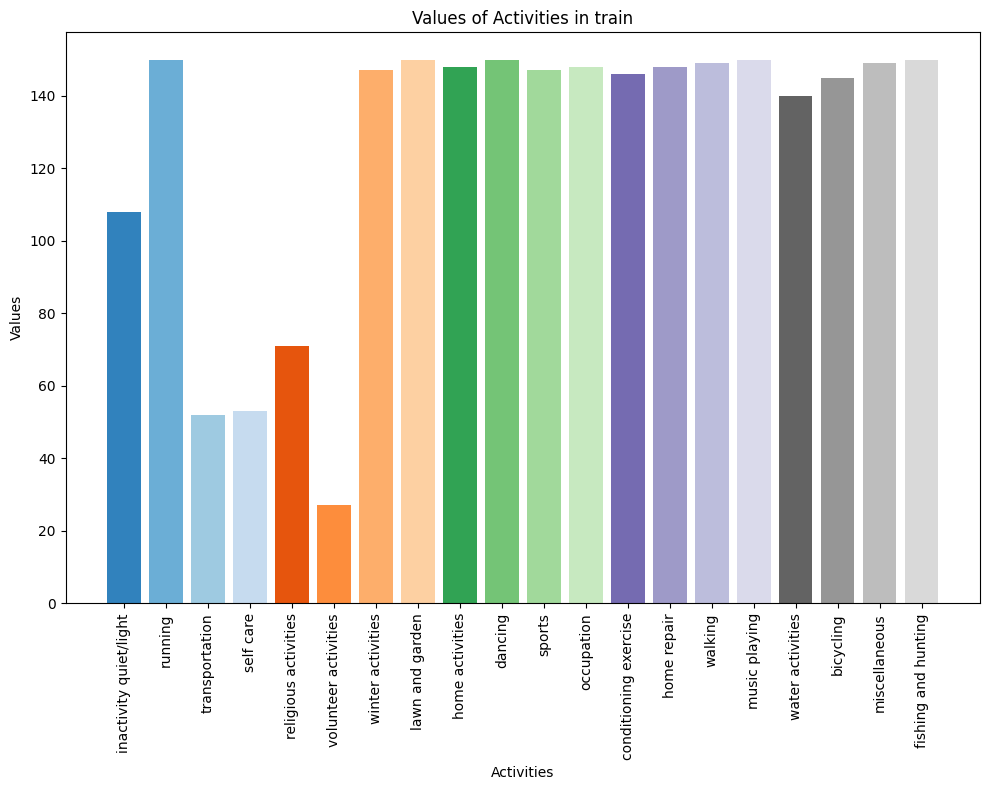

In [57]:
plot_bar_graph(unique_activities_count_train, 'train')

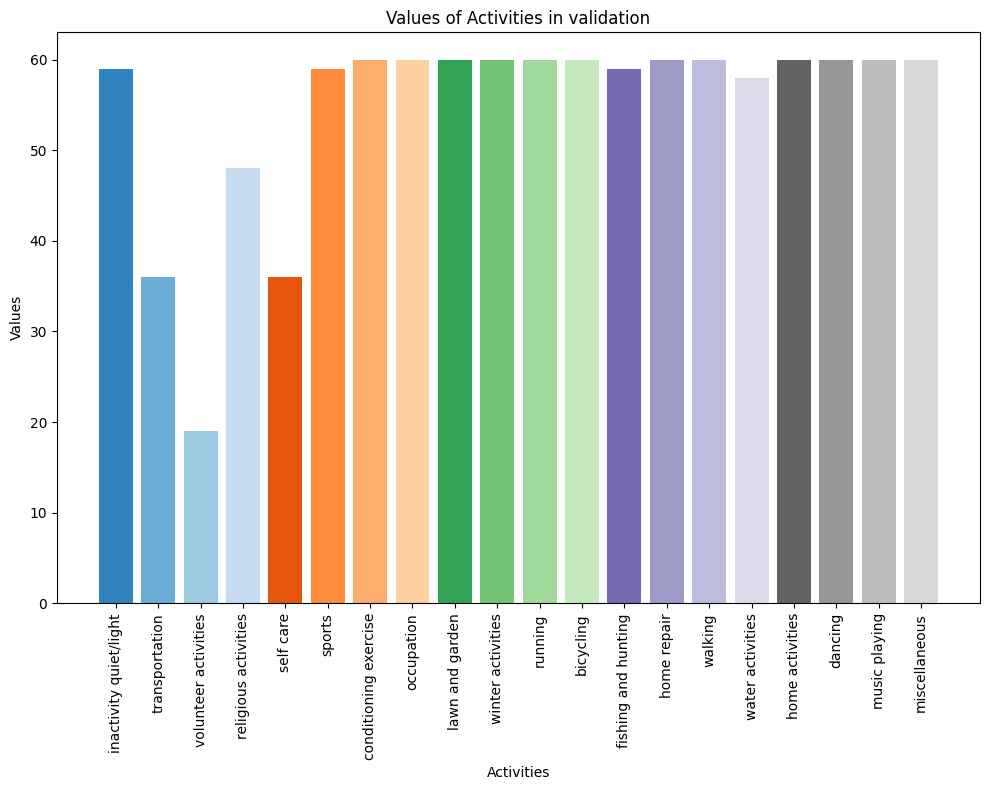

In [58]:
plot_bar_graph(unique_activities_count_val, 'validation')

In [ ]:
## We can see that the train and val set have almost same kind of distribution

In [59]:
fraction_train_to_val = dict()

In [60]:
for activity in unique_activities_count_train.keys():
    fraction_train_to_val[activity] = (unique_activities_count_val[activity] * 1.0) / unique_activities_count_train[activity]

In [61]:
fraction_train_to_val

{'inactivity quiet/light': 0.5462962962962963,
 'running': 0.4,
 'transportation': 0.6923076923076923,
 'self care': 0.6792452830188679,
 'religious activities': 0.676056338028169,
 'volunteer activities': 0.7037037037037037,
 'winter activities': 0.40816326530612246,
 'lawn and garden': 0.4,
 'home activities': 0.40540540540540543,
 'dancing': 0.4,
 'sports': 0.4013605442176871,
 'occupation': 0.40540540540540543,
 'conditioning exercise': 0.410958904109589,
 'home repair': 0.40540540540540543,
 'walking': 0.40268456375838924,
 'music playing': 0.4,
 'water activities': 0.4142857142857143,
 'bicycling': 0.41379310344827586,
 'miscellaneous': 0.40268456375838924,
 'fishing and hunting': 0.3933333333333333}

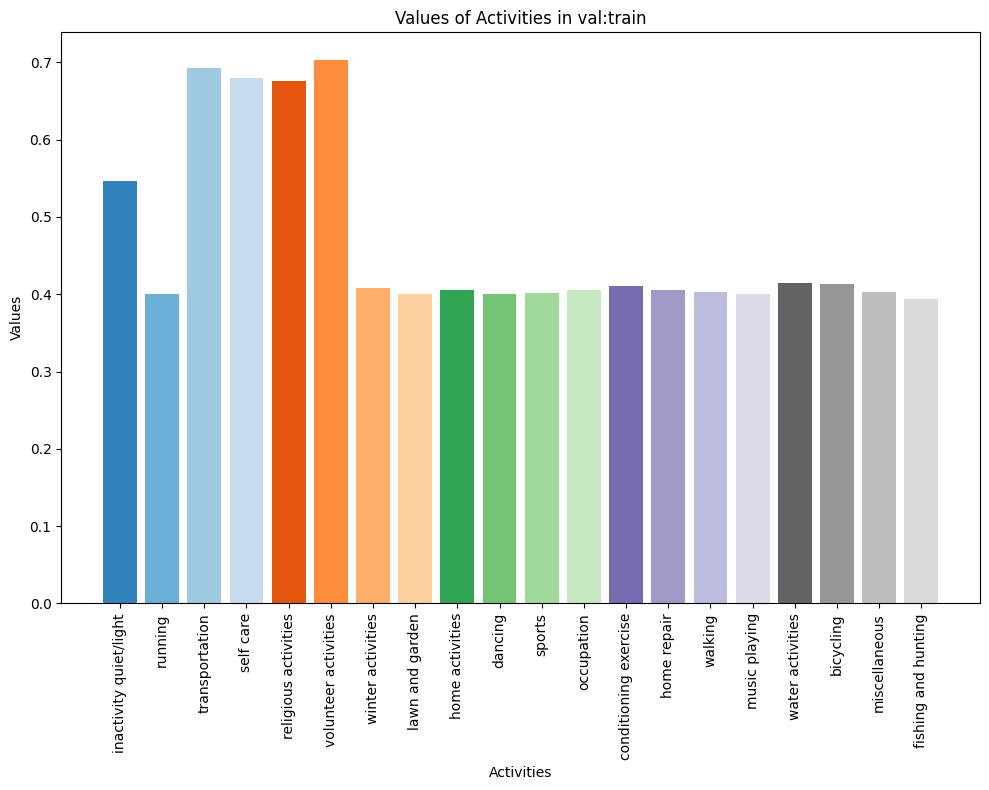

In [62]:
plot_bar_graph(fraction_train_to_val, 'val:train')

In [ ]:
## We can see that the ratio of examples in train and val set for each class is almost 0.45 on average

In [63]:
from utilities.utils import random_plot_image_from_npy_files

In [ ]:
# Visualise the train_data for pose_classification

In [64]:
len(valid_annot_data)

17408

Visualising the training data to check if it was save correctly

[+] Choice 2260 loading 002716130.npy label:15
[+] Saved label:  dancing  and actual_label:  dancing


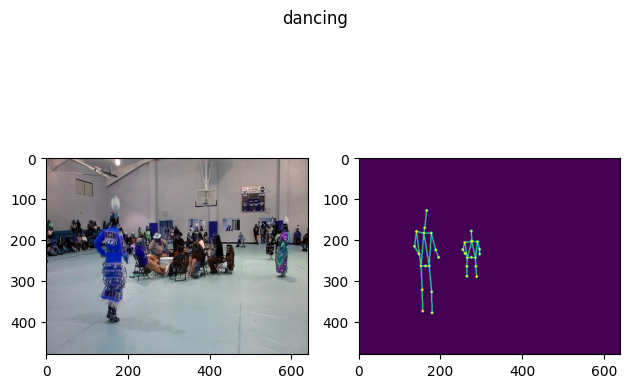

In [65]:
random_plot_image_from_npy_files('../data/processed/train_4_channel_info', '../data/processed/train_labels_pose_class', class_names, valid_annot_data)

Visualising the validation data to check if it was saved correctly

[+] Choice 465 loading 023440145.npy label:16
[+] Saved label:  bicycling  and actual_label:  bicycling


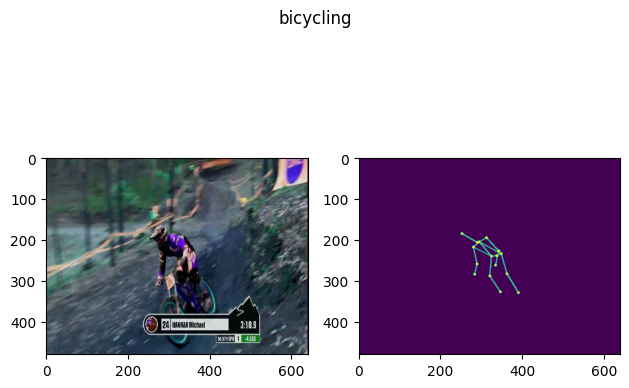

In [66]:
random_plot_image_from_npy_files('../data/processed/val_4_channel_info', '../data/processed/val_labels_pose_class', class_names, valid_annot_data) # 033613048

In [ ]:
## Create the pose dataset instance

Specify the suffix of the respective directories

In [67]:
x_train_suffix = 'train_4_channel_info'
y_train_suffix = 'train_labels_pose_class'

x_val_suffix = 'val_4_channel_info'
y_val_suffix = 'val_labels_pose_class'
dataset_path, x_train_suffix, y_train_suffix, x_val_suffix, y_val_suffix

('../data/processed',
 'train_4_channel_info',
 'train_labels_pose_class',
 'val_4_channel_info',
 'val_labels_pose_class')

In [68]:
x_train = os.listdir(f'{dataset_path}/{x_train_suffix}')
y_train = os.listdir(f'{dataset_path}/{y_train_suffix}')
x_train.sort(), y_train.sort() # so that they matchup i.e x_train[0] labels y_train[0]

(None, None)

In [69]:
x_val = os.listdir(f'{dataset_path}/{x_val_suffix}')
y_val = os.listdir(f'{dataset_path}/{y_val_suffix}')
x_val.sort(), y_val.sort()

(None, None)

In [73]:
x_train[:1], y_train[:1]

(['000085370.npy'], ['000085370.txt'])

In [74]:
from data.pose_classification_data_loader import data_loader

In [75]:
train_dataset, val_dataset = data_loader(dataset_path, x_train, y_train, x_val, y_val, x_train_suffix, y_train_suffix, x_val_suffix, y_val_suffix)

[+] Train=> len_X: 2528 len_Y: 2528
[+] Val=> len_X: 1094 len_Y: 1094


## Just testing

In [61]:
info1, info2 = None, None
label1, label2 = None, None

In [62]:
for batch in train_dataset.take(1):  # Take 5 batches as an example
    print("Batch shape:", batch[0].shape, "Label shape:", batch[1].shape)
    info1 = batch[0][0]
    label1 = batch[1][0]

Batch shape: (32, 480, 640, 4) Label shape: (32,)


In [63]:
for batch in val_dataset.take(1):  # Take 5 batches as an example
    print("Batch shape:", batch[0].shape, "Label shape:", batch[1].shape)
    info2 = batch[0][0]
    label2 = batch[1][0]

Batch shape: (32, 480, 640, 4) Label shape: (32,)


In [64]:
info1.shape

TensorShape([480, 640, 4])

In [66]:
label1

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [67]:
info1 = tf.cast(info1 * 255.0, tf.uint8)
info1

<tf.Tensor: shape=(480, 640, 4), dtype=uint8, numpy=
array([[[  6,  12,   7, 250],
        [ 12,  18,  13, 250],
        [ 34,  41,  36, 250],
        ...,
        [ 32,  48,  41,   0],
        [ 21,  36,  32,   0],
        [ 32,  47,  43,   0]],

       [[ 13,  19,  14, 250],
        [ 12,  18,  13, 250],
        [ 32,  39,  34, 250],
        ...,
        [ 51,  67,  60,   0],
        [ 33,  48,  44,   0],
        [ 33,  48,  44,   0]],

       [[ 11,  17,  12, 250],
        [ 11,  17,  12, 250],
        [ 23,  30,  27, 250],
        ...,
        [ 48,  66,  59,   0],
        [ 43,  59,  52,   0],
        [ 47,  63,  56,   0]],

       ...,

       [[ 29,  26,  28,   0],
        [ 32,  29,  31,   0],
        [ 33,  30,  32,   0],
        ...,
        [168, 188, 229,   0],
        [193, 215, 255,   0],
        [184, 206, 247,   0]],

       [[ 29,  26,  28,   0],
        [ 32,  29,  31,   0],
        [ 33,  30,  32,   0],
        ...,
        [191, 212, 250,   0],
        [187, 209, 25

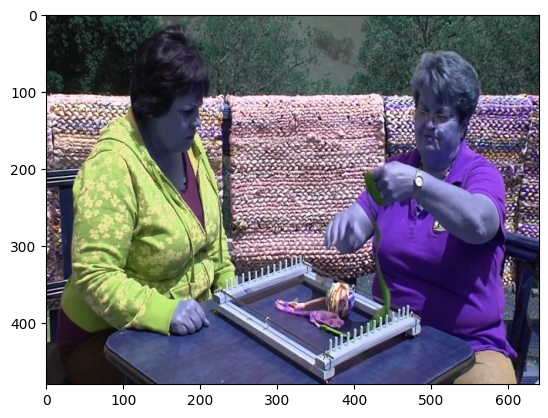

In [68]:
plt.imshow(tf.cast(info1[:, :, :3], tf.uint8))

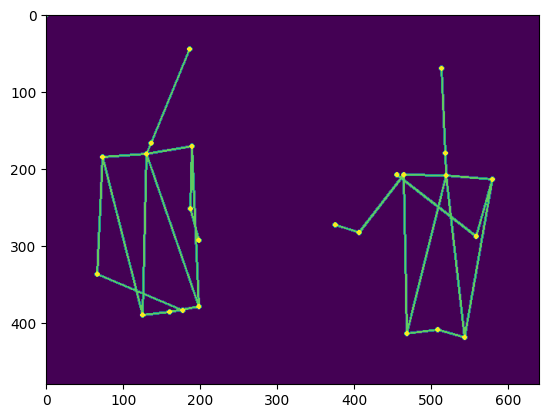

In [69]:
plt.imshow(tf.cast(info1[:, :, 3], tf.uint8))

In [70]:
label2

<tf.Tensor: shape=(), dtype=int32, numpy=18>

In [71]:
info2 = tf.cast(info2 * 255.0, tf.uint8)

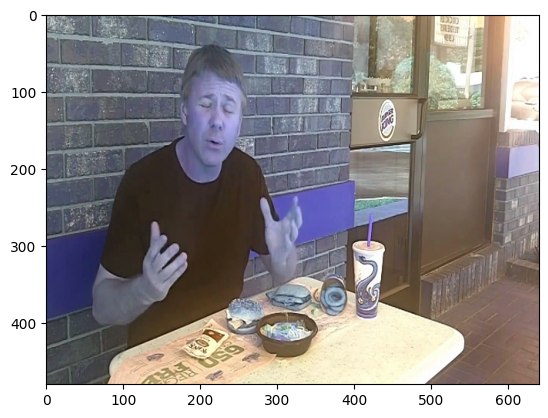

In [72]:
plt.imshow(tf.cast(info2[:, :, :3], tf.uint8))

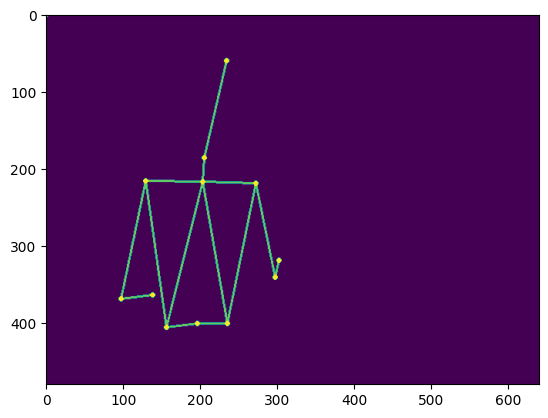

In [73]:
plt.imshow(tf.cast(info2[:, :, 3], tf.uint8))

## Model Building

In [74]:
# Creating the model
backbone = tf.keras.applications.EfficientNetV2B0(include_top=False)
backbone.trainable = False # Freeze the layers of the backbone

input_layer = tf.keras.layers.Input(shape=(480, 640, 4), name="input_layer")

x = tf.keras.layers.Conv2D(filters=4, kernel_size=(3, 3), padding="same")(input_layer)
x = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding="same")(x)

x = backbone(x)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

ouput_layer = tf.keras.layers.Dense(20, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input_layer, ouput_layer)

In [75]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=["accuracy"])

In [76]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 480, 640, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 480, 640, 4)    │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 480, 640, 3)    │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 15, 20, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,945,191 (22.68 MB)

 Trainable params: 25,879 (101.09 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Defining callbacks and model training

In [76]:
import datetime

In [98]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [84]:
# Setup checkpoint path
checkpoint_path = "../logs/pose_classification_stage_checkpoints/checkpoint_pose_classification_based_on_keypoints_predictions.ckpt.weights.h5" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=val_dataset,
                    callbacks=[create_tensorboard_callback(dir_name="../logs/pose_classsification_logs_tensorflow_hub",
                                                                                    # Track logs under different experiment name
                                                                                    experiment_name="pose_classification_based_on_keypoint_estimation"),
                                                                                    checkpoint_callback])

In [86]:
current_time = datetime.datetime.now()
current_time = current_time.strftime("%H:%M:%S")
current_time, type(current_time)

('13:14:15', str)

In [87]:
random_throw = np.random.randint(low=1000, high=50000, size=1)[0]
random_throw

18831

In [88]:
model_save_path = f'../models/pose_classification_{current_time}_{random_throw}.keras'
model_save_path

'../models/pose_classification_13:14:15_18831.keras'

In [89]:
tf.keras.models.save_model(model, model_save_path)

In [90]:
train_accuracy = np.array(history.history['accuracy'])
train_accuracy.shape

(25,)

In [91]:
train_loss = np.array(history.history['loss'])
train_loss

array([     2.9803,      2.9719,      2.9451,      2.8678,      2.6988,      2.4097,       2.103,       1.833,      1.6276,      1.4765,      1.3458,      1.2456,       1.167,      1.0924,      1.0414,       0.999,     0.94737,      0.9065,     0.86927,     0.83507,     0.80497,     0.77493,     0.74743,     0.73217,
           0.70019])

In [92]:
val_accuracy = np.array(history.history['val_accuracy'])
val_accuracy.shape

(25,)

In [93]:
val_loss = np.array(history.history['val_loss'])
val_loss.shape

(25,)

In [94]:
# Write the data to a json file
def write_metrics(metric, path):
    metric = metric.tolist()
    try:
        with open(path, 'w') as file:
            json.dump(metric, file)
        print("[+] Data saved successfully....")
    except Exception as e:
        print("[-] Failed to save data, aborting...")
        print(e)
        return -1
    return 1

In [95]:
# Plotting the curves
# Plot the validation and training data separately
def plot_loss_curves(loss, val_loss, accuracy, val_accuracy, epochs):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  # Plot loss
  epochs = np.arange(1, epochs + 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

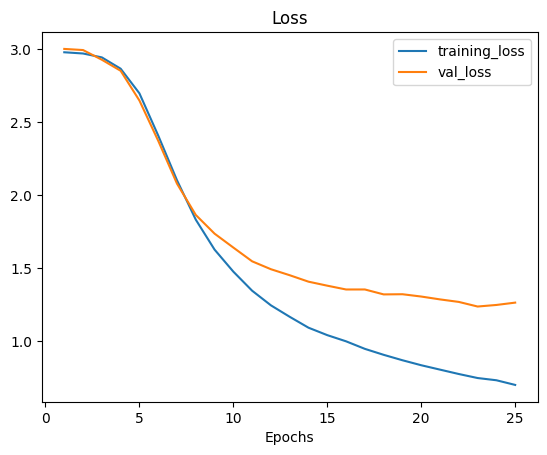

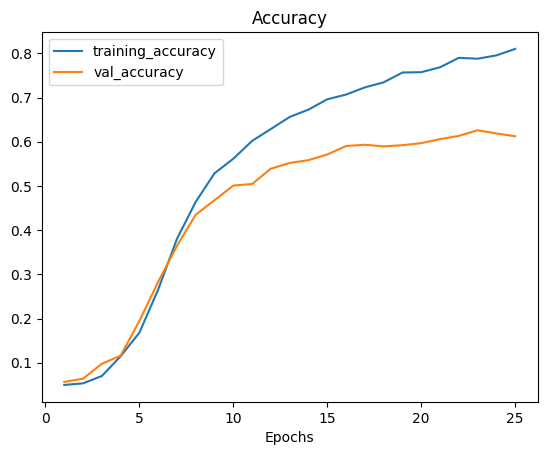

In [96]:
plot_loss_curves(train_loss, val_loss, train_accuracy, val_accuracy, len(train_loss)) # Plot the accuracy and loss graphs

In [ ]:
# Load the model

## Loading the Model

In [2]:
import os

In [10]:
model_path = '../models/pose_classification_13:14:15_18831.keras'

In [11]:
loaded_model = tf.keras.models.load_model(model_path)

/opt/miniconda3/envs/aditya/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 496 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [99]:
y_true, y_pred = [], []
y_true, y_pred

([], [])

In [100]:
for element in val_dataset:
    input_to_feed = element[0]
    output_to_cmp_with = element[1]

    # Make the prediction
    predictions = loaded_model.predict(input_to_feed)

    # Convert to numpy array
    output_to_cmp_with = np.array(output_to_cmp_with)
    predictions = np.array(predictions)
    
    # First we push the true labels
    for i in range(len(output_to_cmp_with)):
        y_true.append(output_to_cmp_with[i])
    
    for i in range(len(predictions)):
        indx = np.argmax(predictions[i])
        y_pred.append(indx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [104]:
len(y_true), len(y_pred)

(1094, 1094)

## Performance Metrics(Precicion and Recall)

In [105]:
from sklearn.metrics import precision_score, recall_score

In [107]:
# Calculate metrics globally by counting the total true positives, false negatives, and false positives.
precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')

In [118]:
print("[+] Micro_precision: ", precision_micro*100, " Micro_recall: ", recall_micro*100)

[+] Micro_precision:  61.24314442413162  Micro_recall:  61.24314442413162


In [116]:
# Calculate metrics for each label and find their unweighted mean. This does not take class imbalance into account.
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

In [120]:
print("[+] Macro_precision: ", precision_macro * 100, " Macro_recall: ", recall_macro * 100)

[+] Macro_precision:  63.521457159494965  Macro_recall:  60.259203434262666


In [110]:
# 'weighted': Calculate metrics for each label and find their average weighted by support (the number of true instances for each label). This accounts for class imbalance.
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

In [119]:
print("[+] Weighted_precision: ", precision_weighted*100, " weighted_recall", recall_weighted*100)

[+] Weighted_precision:  63.2413319175969  weighted_recall 61.24314442413162
